In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report
from models import CNNClassifier
from utils import create_param_list, create_train_data_hold_out, create_train_data_CV
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(3407)

In [5]:
Q = 6
nconf = 81
ndata = 200
L = 64
T_cr_1 = 0.701 # critical temp for 2d clock
T_cr_2 = 0.898 # critical temp for 2d clock
t_start = 0.4

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Clock", q=Q)
# print(prm_list)
print(f"データ数:{nconf*ndata}")

データ数:16200


temperature:0.49


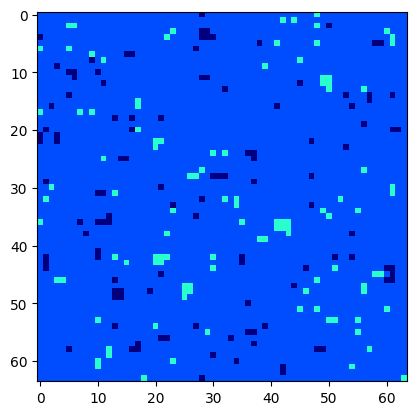

temperature:0.61


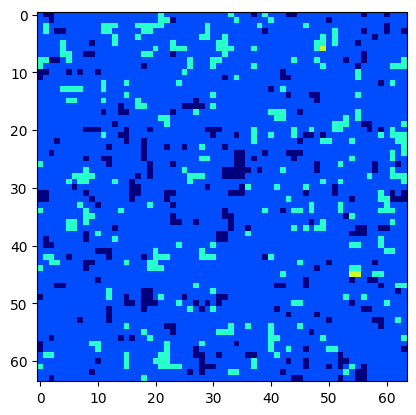

temperature:0.99


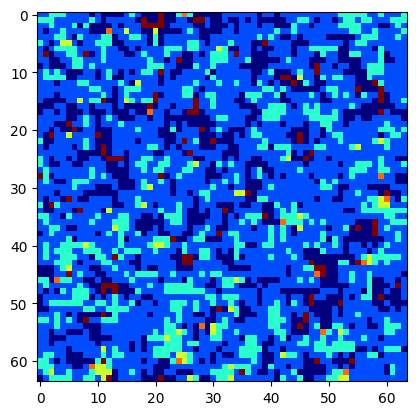

temperature:1.19


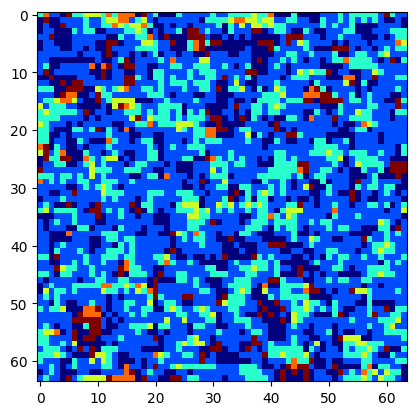

In [7]:
# 可視化
for num in [9, 21, 59, 79]:
    for iconf in range(1):
        file = f"{prm_list[num][1]}{iconf}.npy"
        sc = np.load(file)
        print(f"temperature:{prm_list[num][0]}")
        plt.imshow(sc, interpolation='nearest', vmin=0, vmax=Q-1, cmap='jet')
    plt.show()

In [91]:
# hold out
dataset, _ = create_train_data_CV(prm_list, ndata, T_cr_1, exclude_T=(0.65, ))
print("dataset.shape = ", len(dataset))

In [93]:
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [94]:
epochs = 5
losses = []
accuracy_list = []
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.type(torch.long))
        loss.backward()
        del loss
        optimizer.step()
    
    model.eval()
    valid_loss = 0
    correct = 0
    answer = []
    prediction = []
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)
            valid_loss += criterion(output, target.type(torch.long)).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            prediction += list(pred.cpu().numpy())
            answer += list(target.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100 * correct / len(valid_loader.dataset)
    losses.append(valid_loss)
    accuracy_list.append(accuracy)
    print(f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {accuracy}%')
    print("Classification Report:\n", classification_report(
        answer, prediction, digits=4))
print("done.")
torch.save(model, "2d_Clock_model_classifier.pth")

Epoch: 1, Validation loss: 0.06991386752411993, Accuracy: 51.679586563307495%
Classification Report:
               precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       187
         1.0     0.5168    1.0000    0.6814       200

    accuracy                         0.5168       387
   macro avg     0.2584    0.5000    0.3407       387
weighted avg     0.2671    0.5168    0.3522       387

Epoch: 2, Validation loss: 0.06977192144985347, Accuracy: 51.679586563307495%
Classification Report:
               precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       187
         1.0     0.5168    1.0000    0.6814       200

    accuracy                         0.5168       387
   macro avg     0.2584    0.5000    0.3407       387
weighted avg     0.2671    0.5168    0.3522       387

Epoch: 3, Validation loss: 0.06977148742946851, Accuracy: 51.679586563307495%
Classification Report:
               precision    recall  f1-sc

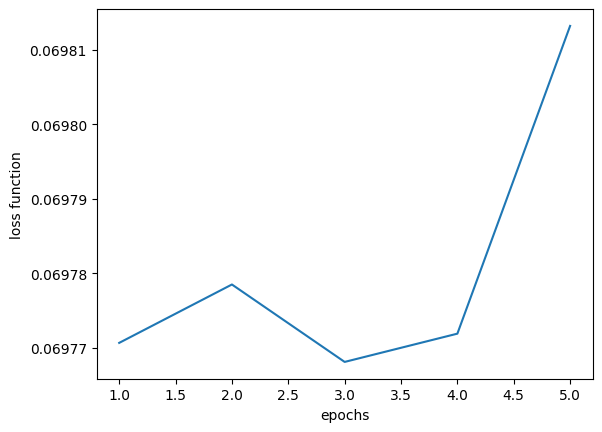

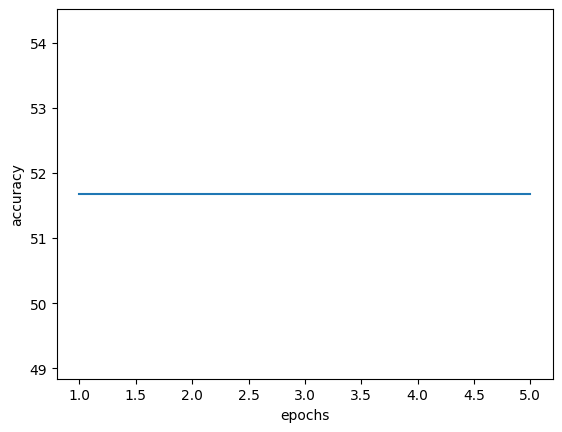

In [87]:
plt.xlabel('epochs')
plt.ylabel('loss function')
plt.plot(np.arange(1, epochs+1), losses)
plt.show()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(np.arange(1, epochs+1), accuracy_list)
plt.show()

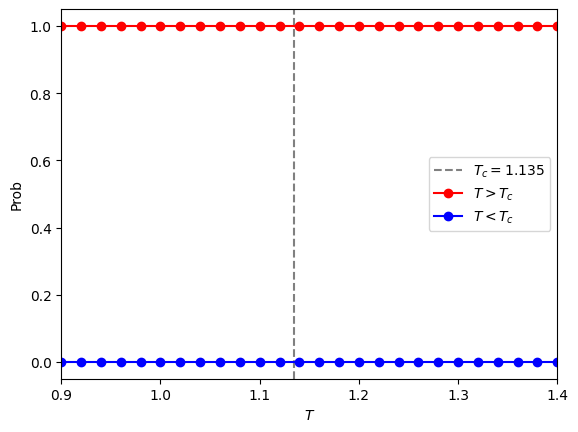

In [88]:
xs = []
y1s = []
y2s = []
Ndatamax = 637
Nsameclass = 25
for j in range(0, Ndatamax, Nsameclass):
    result = model(val_data[j:j+Nsameclass])
    x = val_temps[j]
    y1 = np.mean(result.argmax(dim=1, keepdim=True).detach().numpy().copy())
    y2 = 1 - np.mean(result.argmax(dim=1, keepdim=True).detach().numpy().copy())
    xs.append(x)
    y1s.append(y1)
    y2s.append(y2)
    # print(x, y1, y2)
plt.axvline(x=1.135, ymin=0, ymax=1, ls="dashed", color="gray", label=r"$T_c=1.135$")
plt.xlim(0.9,1.4)
plt.plot(xs, y1s, label=r"$T>T_c$", marker="o", color="red")
plt.plot(xs, y2s, label=r"$T<T_c$", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Prob")
plt.show()